In [40]:
import pandas as pd
import numpy as np
import xgboost as xgb

In [41]:
df = pd.read_csv('feature_allfinal.csv')
df.head()

,route_folder,part_number,filename,trail_id,poi_previous_id,poi_current_id,distance,elevation_range,elevation_change,elevation_gain,elevation_loss,high_elevation,max_slope_percent,max_slope_degrees,max_slope_point,slope_std_dev,slope_variance,slope_freq_dist
0,chiyou,1,chiyou_part1.geojson,3,1,12,1029.42,99.7,82.97,99.9,14.5,False,50.76,26.91,"(24.405129, 121.307518)",9.15,83.73,"{'<-15°': 0.0, '-15°~-10°': 5.56, '-10°~-5°': ..."
1,chiyou,2,chiyou_part2.geojson,3,12,7,2416.44,243.3,100.70,267.9,24.6,False,37.42,20.51,"(24.405757, 121.302698)",6.81,46.36,"{'<-15°': 0.0, '-15°~-10°': 0.0, '-10°~-5°': 1..."
2,chiyou,3,chiyou_part3.geojson,3,7,10,2425.73,753.0,309.23,767.4,17.3,True,164.33,58.68,"(24.409900, 121.301215)",14.44,208.54,"{'<-15°': 4.29, '-15°~-10°': 1.43, '-10°~-5°':..."
3,chiyou,4,chiyou_part4.geojson,3,10,21,1471.22,331.3,219.03,342.3,20.1,True,62.69,32.08,"(24.429492, 121.290884)",11.18,125.06,"{'<-15°': 3.03, '-15°~-10°': 3.03, '-10°~-5°':..."
4,chiyou,5,chiyou_part5.geojson,3,21,10,1471.22,331.3,-219.03,20.1,342.3,True,-62.69,-32.08,"(24.429348, 121.291071)",11.18,125.06,"{'<-15°': 36.36, '-15°~-10°': 12.12, '-10°~-5°..."


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   route_folder       110 non-null    object 
 1   part_number        110 non-null    int64  
 2   filename           110 non-null    object 
 3   trail_id           110 non-null    int64  
 4   poi_previous_id    110 non-null    int64  
 5   poi_current_id     110 non-null    int64  
 6   distance           110 non-null    float64
 7   elevation_range    110 non-null    float64
 8   elevation_change   110 non-null    float64
 9   elevation_gain     110 non-null    float64
 10  elevation_loss     110 non-null    float64
 11  high_elevation     110 non-null    bool   
 12  max_slope_percent  110 non-null    float64
 13  max_slope_degrees  110 non-null    float64
 14  max_slope_point    110 non-null    object 
 15  slope_std_dev      110 non-null    float64
 16  slope_variance     110 non

In [43]:
# 數據預處理
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import ast

print("資料形狀:", df.shape)
print("\n目標變數分布:")
print(df['high_elevation'].value_counts())


資料形狀: (110, 18)

目標變數分布:
high_elevation
True     88
False    22
Name: count, dtype: int64


In [44]:
# 特徵選擇 - 選擇數值特徵
feature_columns = [
    'distance', 'elevation_range', 'elevation_change', 
    'elevation_gain', 'elevation_loss', 'max_slope_percent', 
    'max_slope_degrees', 'slope_std_dev', 'slope_variance'
]

# 編碼分類特徵
le_route = LabelEncoder()
df['route_folder_encoded'] = le_route.fit_transform(df['route_folder'])

# 最終特徵集
X_features = feature_columns + ['route_folder_encoded', 'part_number', 'trail_id']
X = df[X_features]
y = df['high_elevation'].astype(int)  # 轉換為0/1

print("特徵欄位:", X_features)
print("特徵矩陣形狀:", X.shape)
print("目標變數形狀:", y.shape)


特徵欄位: ['distance', 'elevation_range', 'elevation_change', 'elevation_gain', 'elevation_loss', 'max_slope_percent', 'max_slope_degrees', 'slope_std_dev', 'slope_variance', 'route_folder_encoded', 'part_number', 'trail_id']
特徵矩陣形狀: (110, 12)
目標變數形狀: (110,)


In [45]:
# XGBoost 參數設定（可調整變數）
xgb_params = {
    # 基本參數
    'objective': 'binary:logistic',
    'random_state': 42,
    
    # 模型複雜度控制
    'max_depth': 6,              # 樹的最大深度
    'min_child_weight': 1,       # 葉子節點最小權重
    'gamma': 0,                  # 最小分割損失
    'subsample': 0.8,            # 樣本採樣比例
    'colsample_bytree': 0.8,     # 特徵採樣比例
    
    # 學習參數
    'learning_rate': 0.1,        # 學習率
    'n_estimators': 100,         # 樹的數量
    
    # 正則化參數
    'reg_alpha': 0,              # L1正則化
    'reg_lambda': 1,             # L2正則化
    
    # 其他參數
    'scale_pos_weight': 1,       # 正負樣本權重比
    'eval_metric': 'logloss'     # 評估指標
}

print("XGBoost 參數設定:")
for key, value in xgb_params.items():
    print(f"  {key}: {value}")


XGBoost 參數設定:
  objective: binary:logistic
  random_state: 42
  max_depth: 6
  min_child_weight: 1
  gamma: 0
  subsample: 0.8
  colsample_bytree: 0.8
  learning_rate: 0.1
  n_estimators: 100
  reg_alpha: 0
  reg_lambda: 1
  scale_pos_weight: 1
  eval_metric: logloss


In [46]:
# 分割訓練測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"訓練集: {X_train.shape}, 測試集: {X_test.shape}")
print(f"訓練集正樣本比例: {y_train.mean():.3f}")
print(f"測試集正樣本比例: {y_test.mean():.3f}")


訓練集: (88, 12), 測試集: (22, 12)
訓練集正樣本比例: 0.795
測試集正樣本比例: 0.818


In [47]:
# 建立和訓練 XGBoost 模型
# 將 early_stopping_rounds 加入參數中
xgb_params_train = xgb_params.copy()
xgb_params_train['early_stopping_rounds'] = 10

model = xgb.XGBClassifier(**xgb_params_train)

# 訓練模型
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

print("模型訓練完成！")


模型訓練完成！


In [48]:
# 模型預測和評估
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 計算準確率
accuracy = accuracy_score(y_test, y_pred)

print(f"測試集準確率: {accuracy:.4f}")
print(f"\n分類報告:")
print(classification_report(y_test, y_pred))

print(f"\n混淆矩陣:")
print(confusion_matrix(y_test, y_pred))


測試集準確率: 0.9091

分類報告:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.94      0.94      0.94        18

    accuracy                           0.91        22
   macro avg       0.85      0.85      0.85        22
weighted avg       0.91      0.91      0.91        22


混淆矩陣:
[[ 3  1]
 [ 1 17]]


特徵重要性排序:
1. slope_variance: 0.2510
2. slope_std_dev: 0.1849
3. trail_id: 0.1504
4. elevation_range: 0.1028
5. elevation_change: 0.0712
6. distance: 0.0627
7. elevation_gain: 0.0372
8. max_slope_percent: 0.0331
9. route_folder_encoded: 0.0287
10. elevation_loss: 0.0287
11. part_number: 0.0274
12. max_slope_degrees: 0.0218

=== 特徵重要性分析 ===
1. slope_variance (25.1%) - 坡度變異數是最重要的特徵
2. slope_std_dev (18.5%) - 坡度標準差次之
3. trail_id (15.0%) - 不同路線有顯著差異
4. elevation_range (10.3%) - 海拔範圍也很重要

=> 坡度相關特徵(variance + std_dev)占43.6%，是判斷高海拔的關鍵指標


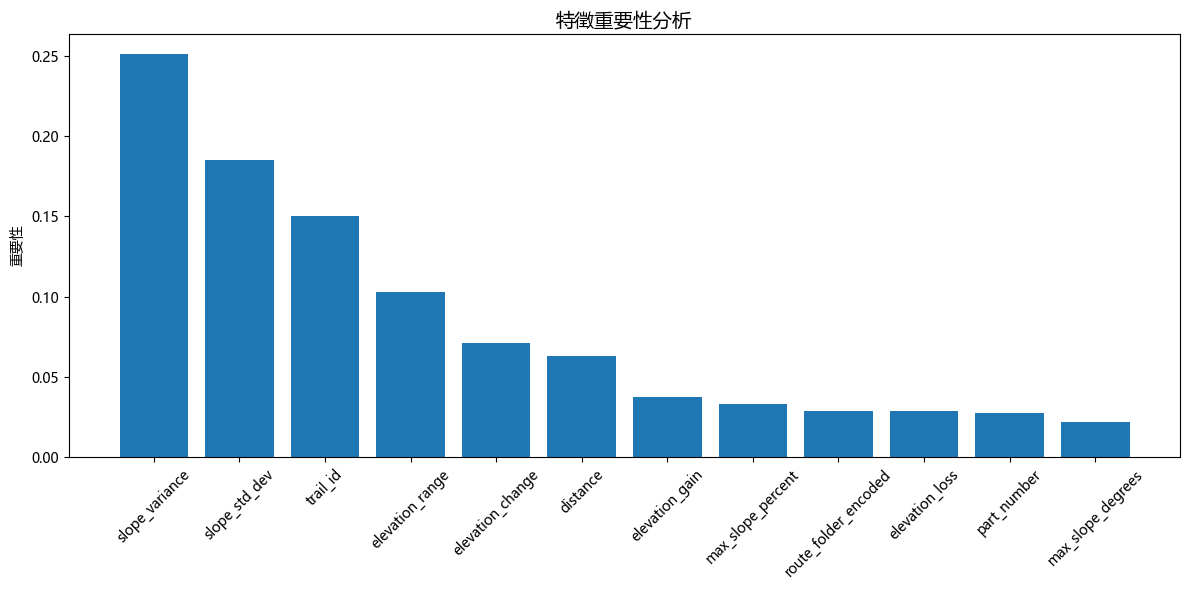

In [49]:
# 特徵重要性分析
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']  # 設定中文字體
plt.rcParams['axes.unicode_minus'] = False  # 正常顯示負號

feature_importance = model.feature_importances_
feature_names = X_features

# 排序特徵重要性
indices = np.argsort(feature_importance)[::-1]

print("特徵重要性排序:")
for i in range(len(feature_names)):
    print(f"{i+1}. {feature_names[indices[i]]}: {feature_importance[indices[i]]:.4f}")

# 特徵重要性分析結果
print("\n=== 特徵重要性分析 ===")
print("1. slope_variance (25.1%) - 坡度變異數是最重要的特徵")
print("2. slope_std_dev (18.5%) - 坡度標準差次之")
print("3. trail_id (15.0%) - 不同路線有顯著差異")
print("4. elevation_range (10.3%) - 海拔範圍也很重要")
print("\n=> 坡度相關特徵(variance + std_dev)占43.6%，是判斷高海拔的關鍵指標")

# 繪製特徵重要性圖
plt.figure(figsize=(12, 6))
plt.title("特徵重要性分析", fontsize=14)
plt.bar(range(len(feature_names)), feature_importance[indices])
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
plt.ylabel("重要性")
plt.tight_layout()
plt.show()
